# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))))


# Imports

In [3]:
import plotter
import datahandler

import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display


# Constants

In [4]:
FOLDER_NAME = "ex_1_avg_NONE"
DATE_BOUNDS = ("2017-05-15 07:00:00", "2017-05-15 18:59:59")

FOLDER_PATH = os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data", FOLDER_NAME)


In [5]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(False, False, True)


Loading dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


# Methods

In [6]:
def load_csv(filename = "events"):
    dataframe = pd.read_csv(os.path.join(FOLDER_PATH, filename + ".csv"))

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban']):
        if triage == 'V1':
            continue
    
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [7]:
def plot_response_time_density(df):
    matplotlib.pyplot.figure(figsize=(12, 8))

    for triage_category in ["A", "H", "V1"]:
        subset = df[df['triage_impression_during_call'] == triage_category]
        sns.kdeplot(subset['total_response_time'] / 60, bw_adjust=0.5, label=f'Triage {triage_category}', fill=True)

    matplotlib.pyplot.title('Response Time Density by Triage Category')
    matplotlib.pyplot.xlabel('Response Time (minutes)')
    matplotlib.pyplot.ylabel('Density')
    matplotlib.pyplot.xlim(left=0)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()


In [8]:
def print_mean_median(df: pd.DataFrame):
    stats = df.groupby(['triage_impression_during_call', 'urban']).agg({
        'total_response_time': ['mean', 'median'],
        'complied': 'mean'
    }).reset_index()

    stats.columns = ['Triage', 'Urban', 'Mean Response Time', 'Median Response Time', 'Compliance Rate']

    # convert response times from seconds to minutes
    stats['Mean Response Time'] = (stats['Mean Response Time'] / 60).round(2)
    stats['Median Response Time'] = (stats['Median Response Time'] / 60).round(2)

    # convert the compliance rate to percentage
    stats['Compliance Rate'] = stats['Compliance Rate'].apply(lambda x: f"{x*100:.2f}%" if pd.notna(x) else "N/A")

    # map boolean 'Urban' to 'Yes' or 'No'
    stats['Urban'] = stats['Urban'].map({True: 'Yes', False: 'No'})

    stats.sort_values(by=["Urban", "Triage"], ascending=[False, True], inplace=True)

    IPython.display.display(stats.style.hide(axis='index'))


In [9]:
def boxplot_time_at_steps_modified(
    dataframe: pd.DataFrame,
    triage_impression: str = None
):
    title = "Time Taken At Each Step of the Incident"

    if triage_impression is not None:
        # filter the dataframe without overwriting the original one
        temp_df = dataframe[dataframe["triage_impression_during_call"] == triage_impression].copy()
        title += f" ({triage_impression})"
    else:
        # use the original dataframe if no triage_impression filter is applied
        temp_df = dataframe.copy()

    steps = {
        "Creating Incident": "duration_incident_creation",
        "Appointing Resource": "duration_resource_appointment",
        "Resource to Start Task": "duration_resource_preparing_departure",
        "Dispatching to Scene": "duration_dispatching_to_scene",
        "At Scene": "duration_at_scene",
        "Dispatching to Hospital": "duration_dispatching_to_hospital",
        "At Hospital": "duration_at_hospital"
    }

    # calculating durations for each step
    plot_data = [(temp_df[duration_column][temp_df[duration_column] > 0] / 60) for step, duration_column in steps.items()]

    # plotting
    matplotlib.pyplot.figure(figsize=(8, 4))
    matplotlib.pyplot.boxplot(plot_data[::-1], labels=list(steps.keys())[::-1], vert=False, patch_artist=True, showfliers=False)
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.xlabel("Time in Minutes")
    matplotlib.pyplot.xticks()
    matplotlib.pyplot.show()


In [10]:
def boxplot_time_at_steps(
    historic_dataframe: pd.DataFrame,
    simulated_dataframe: pd.DataFrame,
    bounds: tuple[str, str] = None,
    triage_impressions: list[str] = ["A", "H", "V1"],
):
    historic_df = historic_dataframe.copy()
    simulated_df = simulated_dataframe.copy()
    
    # filter historic data by time frame
    if bounds is not None:
        start_bound, end_bound = pd.to_datetime(bounds[0]), pd.to_datetime(bounds[1])
        historic_df = historic_df[(historic_df['time_call_received'] >= start_bound) & (historic_df['time_call_received'] <= end_bound)]

    # calculate duration at each stage in minutes (simulated dataframe already has this calculated)
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            historic_df.loc[historic_df[times[1]].isna(), step] = (historic_df[times[2]] - historic_df[times[0]]).dt.total_seconds() / 60
            historic_df.loc[~historic_df[times[1]].isna(), step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
        else:
            historic_df[step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
    
    # convert seconds to minutes and replace zeros in simulated data to nan
    for step in historic_steps.keys():
        simulated_df[step] /= 60

    simulated_df[["duration_dispatching_to_hospital", "duration_at_hospital"]] = simulated_df[["duration_dispatching_to_hospital", "duration_at_hospital"]].replace(0, np.nan)

    # plot data
    matplotlib.pyplot.figure(figsize=(8, 8))

    data = []
    positions = []
    labels = []
    colors = []
    stripes = []

    i = 0
    for step in historic_steps.keys():
        labels.append(f"{step}")
        for triage in triage_impressions:
            for df, stripe, alpha in zip([historic_df, simulated_df], [False, True], [1.00, 0.65]):
                data.append(df[df['triage_impression_during_call'] == triage][step].dropna())

                labels.append("")

                if (triage == "A"):
                    colors.append([1.00, 0.37, 0.28, alpha])
                elif (triage == "H"):
                    colors.append([0.12, 0.56, 1.00, alpha])
                else:
                    colors.append([0.20, 0.80, 0.20, alpha])

                stripes.append(stripe)

                positions.append(i)
                i += 0.75
        labels.pop()
        i += 1

    bplot = matplotlib.pyplot.boxplot(
        data[::-1],
        labels=labels[::-1],
        positions=positions,
        vert=False,
        patch_artist=True,
        showfliers=True
    )

    for patch, color, stripe in zip(bplot["boxes"], colors[::-1], stripes[::-1]):
        patch.set_facecolor(color)

    matplotlib.pyplot.title("Time Taken At Each Step of the Incident")
    matplotlib.pyplot.xlabel("Time in Minutes")
    matplotlib.pyplot.xticks()
    matplotlib.pyplot.show()


# Main

In [11]:
df = load_csv(filename="events_strategy=closest_prioritizeTriage=false_responseRestricted=false_scheduleBreaks=false")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   time_call_received                     209 non-null    object 
 1   triage_impression_during_call          209 non-null    object 
 2   grid_id                                209 non-null    int64  
 3   urban                                  209 non-null    bool   
 4   allocation_index                       209 non-null    int64  
 5   ambulance_id                           209 non-null    int64  
 6   dispatched_from_depot_index            209 non-null    int64  
 7   duration_incident_creation             209 non-null    int64  
 8   duration_resource_appointment          209 non-null    int64  
 9   duration_resource_preparing_departure  209 non-null    int64  
 10  duration_dispatching_to_scene          209 non-null    int64  
 11  durati

C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


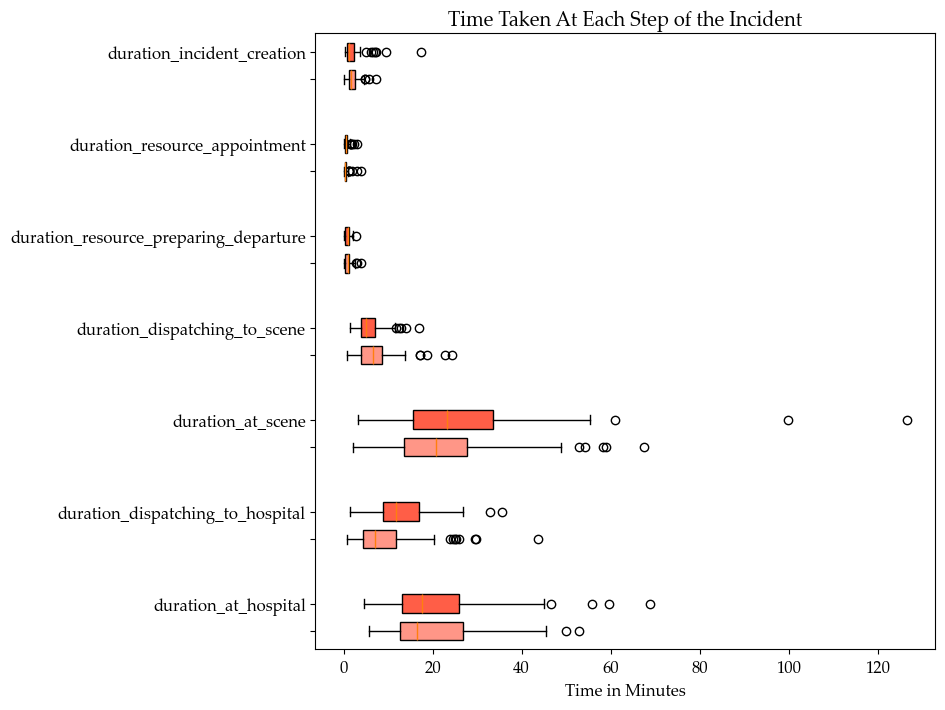

In [12]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["A"]
)


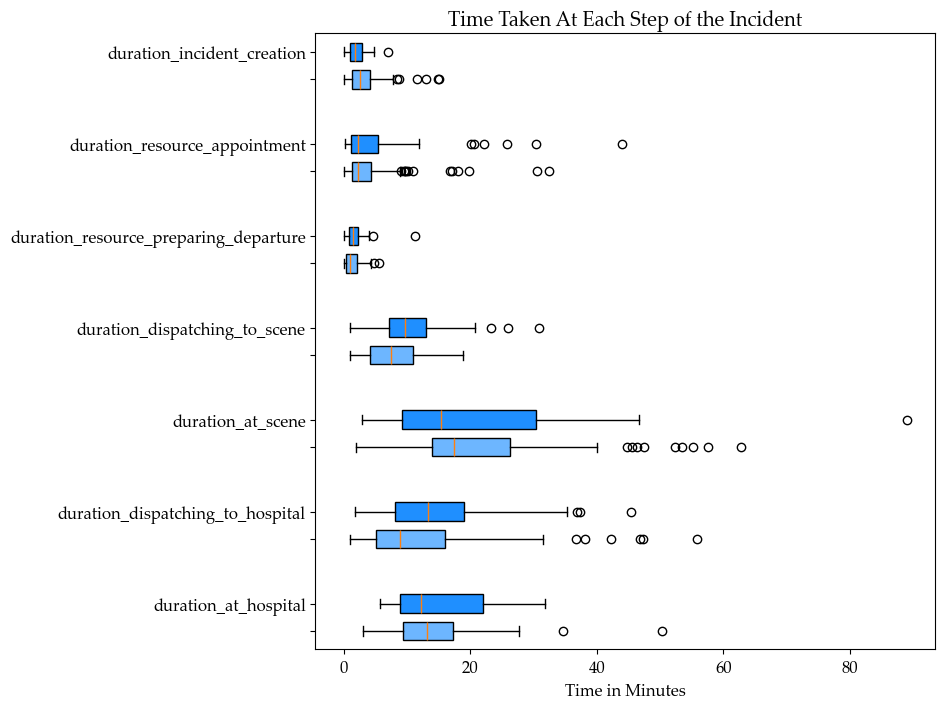

In [13]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["H"]
)

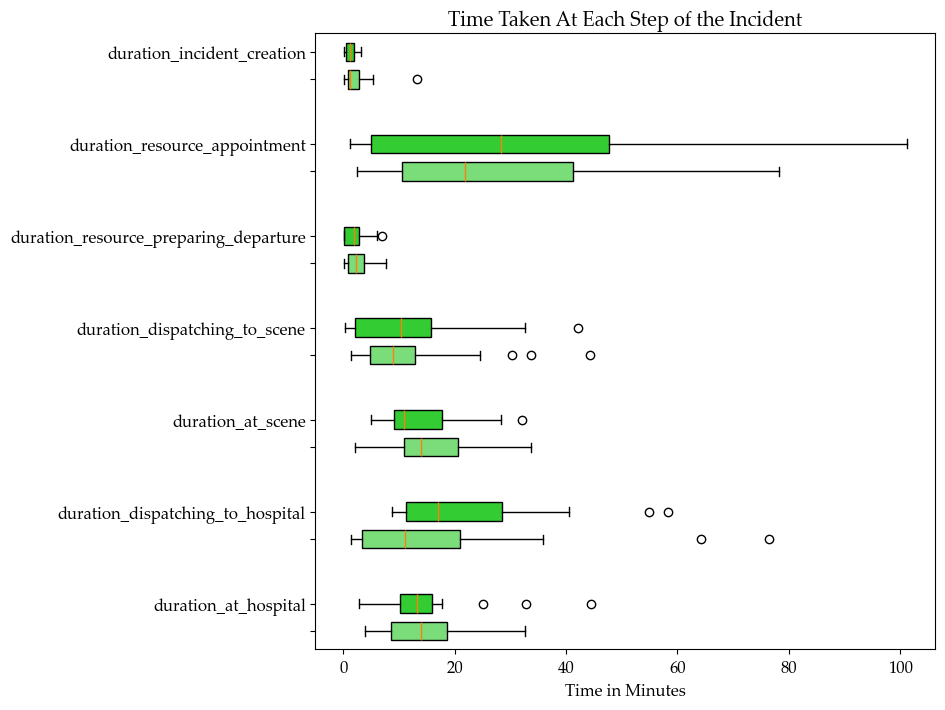

In [14]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["V1"]
)

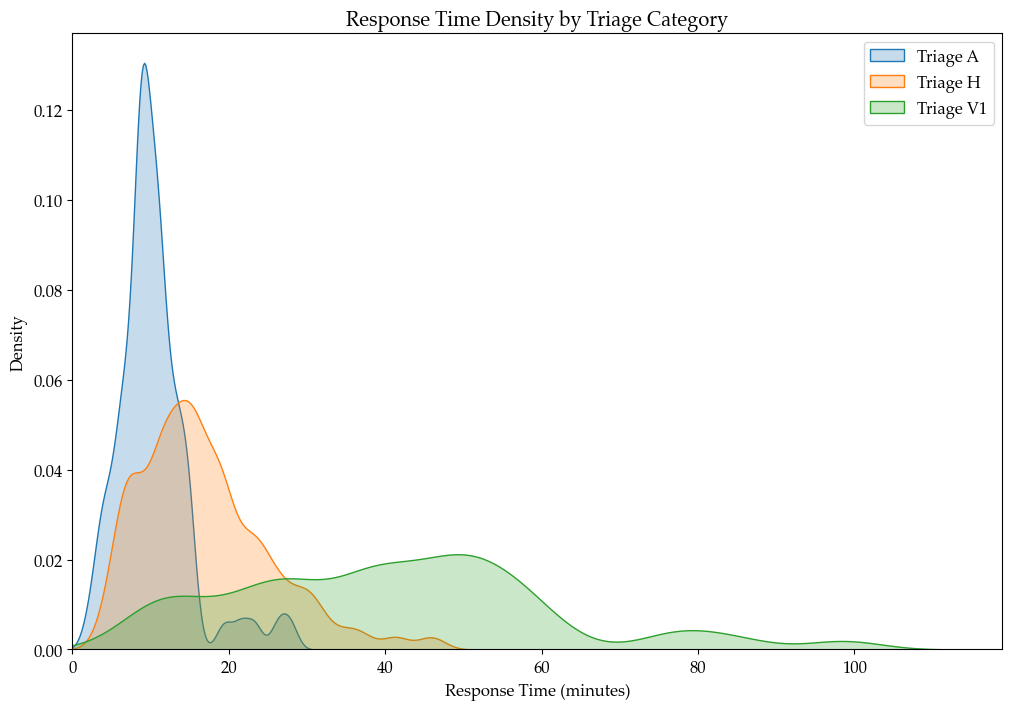

In [15]:
plot_response_time_density(df)


In [16]:
schedule_breaks = False
prioritize_triage = False
response_restricted = False

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,9.930000,9.370000,77.78%
H,Yes,16.920000,15.490000,91.67%
V1,Yes,40.470000,39.330000,N/A
A,No,18.500000,18.930000,75.00%
H,No,17.510000,17.280000,100.00%
V1,No,44.800000,51.430000,N/A


In [17]:
schedule_breaks = False
prioritize_triage = False
response_restricted = True

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,11.830000,10.860000,63.89%
H,Yes,16.900000,15.270000,91.67%
V1,Yes,39.010000,38.350000,N/A
A,No,20.230000,21.610000,50.00%
H,No,18.180000,18.770000,100.00%
V1,No,44.900000,51.430000,N/A


In [18]:
schedule_breaks = False
prioritize_triage = True
response_restricted = False

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,9.690000,9.100000,76.39%
H,Yes,16.990000,15.480000,90.48%
V1,Yes,42.040000,39.600000,N/A
A,No,18.610000,18.830000,75.00%
H,No,17.450000,17.170000,100.00%
V1,No,44.880000,51.530000,N/A


In [19]:
schedule_breaks = False
prioritize_triage = True
response_restricted = True

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,11.150000,10.030000,65.28%
H,Yes,18.000000,16.420000,89.29%
V1,Yes,42.230000,39.430000,N/A
A,No,20.400000,21.550000,50.00%
H,No,17.570000,17.380000,100.00%
V1,No,44.780000,51.420000,N/A


In [20]:
schedule_breaks = True
prioritize_triage = False
response_restricted = False

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,10.400000,9.860000,72.22%
H,Yes,17.790000,15.880000,89.29%
V1,Yes,41.820000,39.450000,N/A
A,No,18.750000,18.830000,75.00%
H,No,17.620000,17.430000,100.00%
V1,No,44.980000,51.460000,N/A


In [21]:
schedule_breaks = True
prioritize_triage = False
response_restricted = True

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,12.470000,10.850000,59.72%
H,Yes,17.300000,15.580000,90.48%
V1,Yes,42.050000,40.020000,N/A
A,No,24.280000,22.150000,50.00%
H,No,17.560000,17.370000,100.00%
V1,No,44.800000,51.550000,N/A


In [22]:
schedule_breaks = True
prioritize_triage = True
response_restricted = False

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,9.920000,9.300000,73.61%
H,Yes,17.540000,15.930000,89.29%
V1,Yes,46.380000,43.670000,N/A
A,No,18.470000,18.770000,75.00%
H,No,17.320000,17.330000,100.00%
V1,No,44.800000,51.490000,N/A


In [23]:
schedule_breaks = True
prioritize_triage = True
response_restricted = True

print_mean_median(
    load_csv(filename=f"events_strategy=closest_prioritizeTriage={prioritize_triage}_responseRestricted={response_restricted}_scheduleBreaks={schedule_breaks}")
)


C:\Users\sindr\AppData\Local\Temp\ipykernel_19872\1818229282.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


Triage,Urban,Mean Response Time,Median Response Time,Compliance Rate
A,Yes,11.380000,10.550000,65.28%
H,Yes,18.120000,16.040000,88.10%
V1,Yes,44.300000,39.570000,N/A
A,No,20.260000,21.480000,50.00%
H,No,17.320000,17.290000,100.00%
V1,No,44.860000,51.520000,N/A


In [24]:
df["triage_impression_during_call"].value_counts()


triage_impression_during_call
H     88
A     76
V1    45
Name: count, dtype: int64